In [1]:
import numpy as np
import pickle
import SimpleITK as sitk
import matplotlib.pyplot as plt

from cardiac import cadc_load, cadc_locate,cadc_reorient, cadc_generate, cadc_segment, cadc_integrate,cadc_perfusion
from cardiac.cadc_interface import compute_cardiac_gate_function
from cardiac.cadc_segment import smooth_segmentation_and_translate_to_la_axis_1

In [2]:
# 载入数据
sitk_img = sitk.ReadImage('./demo_5samples/000652515.nii.gz')
# z,x,y 81, 80, 80/ min value: 0
ori_img = sitk.GetArrayFromImage(sitk_img)
# 限制最大信号量
ori_img[ori_img > 50] = 50  
# {'X': 6.64, 'Y': 6.64, 'Z': 6.64} 
pixel_size = [6.64, 6.64, 6.64]
img_size = [81, 80, 80]
# 存在心脏的起止切片大致范围
approx_start_z_ind, approx_end_z_ind = int(73.084 / pixel_size[0]), int(305.624 / pixel_size[0]) 

print(approx_start_z_ind, approx_end_z_ind)

11 46


In [3]:
car_img, car_bidx, spr_dict, car_ofs, car_idx = (
            cadc_locate.determinate_cardiac_area(ori_img, (approx_start_z_ind, approx_end_z_ind), pixel_size))

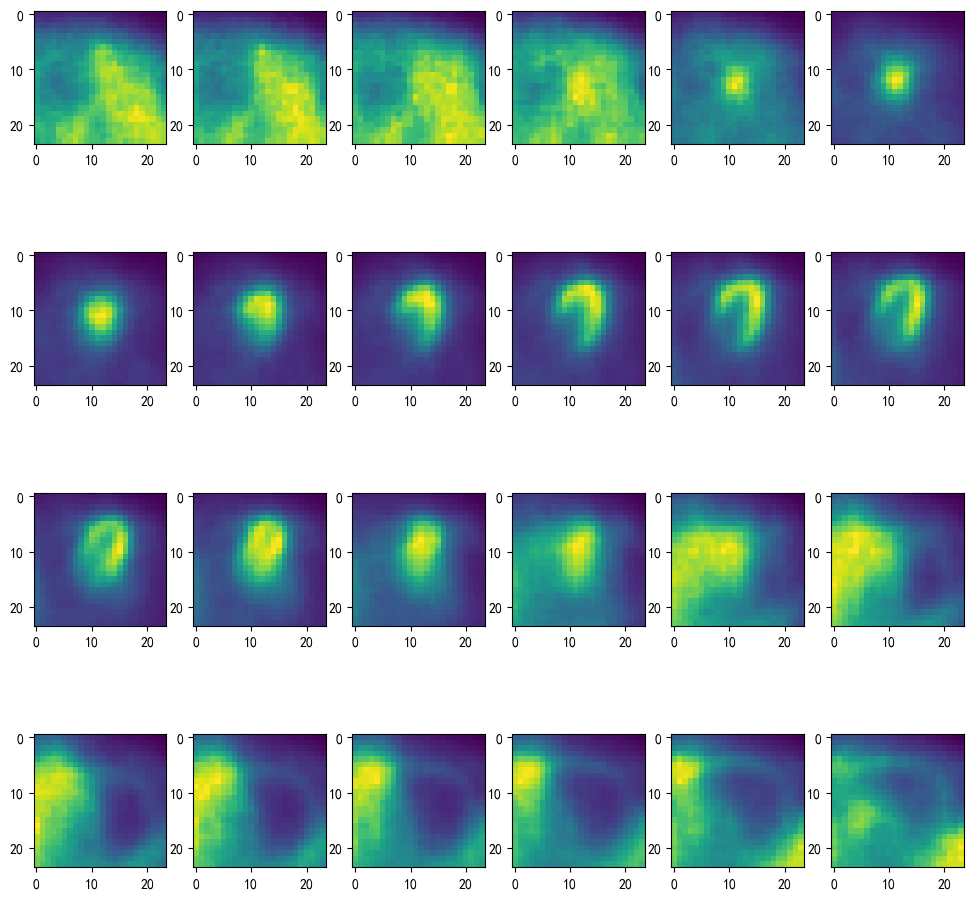

In [4]:
plt.figure(figsize=(12,12))

for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(car_img[i])

In [5]:
la_agl_xy, la_agl_z, axhl_dict, axvl_dict = cadc_reorient.determinate_cardiac_axes(car_img, car_idx)

In [6]:
sa_img, vla_img, hla_img, sa_img_dict, vla_img_dict, hla_img_dict, vtc_img_dict, hrz_img_dict = \
        (cadc_generate.generate_three_views_locate_images(ori_img, car_img, la_agl_xy, la_agl_z, pixel_size, car_ofs))

In [7]:
# 分割长短轴图像
sa_scl_img, sa_msk_img, sa_3d_msk_img, ctr_dict, lv_inf = (
    cadc_segment.segment_short_and_long_axis_images_1(sa_img, vla_img, hla_img))

In [8]:
ed_ctr_dict, ed_sa_3d_msk_img = (
                smooth_segmentation_and_translate_to_la_axis_1(sa_scl_img, 0, 0, sa_msk_img, 0, car_idx))

In [18]:
# ed_ctr_dict

In [10]:
itk_sa = sitk.GetImageFromArray(sa_scl_img)

# 可选：设置图像元数据，例如方向、间距和原点
itk_sa.SetSpacing((1.0, 1.0, 2.67))  # 设置像素间距
itk_sa.SetOrigin((0.0, 0.0, 0.0))   # 设置原点
itk_sa.SetDirection([1.0, 0.0, 0.0,  # 设置方向余弦
                        0.0, 1.0, 0.0,
                        0.0, 0.0, 1.0])

output_file_path = "./sa_and_mask/000652515_scale_img.nii.gz"
sitk.WriteImage(itk_sa, output_file_path)

itk_mask = sitk.GetImageFromArray(sa_msk_img)

# 可选：设置图像元数据，例如方向、间距和原点
itk_mask.SetSpacing((1.0, 1.0, 2.67))  # 设置像素间距
itk_mask.SetOrigin((0.0, 0.0, 0.0))   # 设置原点
itk_mask.SetDirection([1.0, 0.0, 0.0,  # 设置方向余弦
                        0.0, 1.0, 0.0,
                        0.0, 0.0, 1.0])

output_file_path = "./sa_and_mask/000652515_scale_mask.nii.gz"
sitk.WriteImage(itk_mask, output_file_path)

In [1]:
import numpy as np
from skimage import measure
import pyvista as pv
from scipy.ndimage import gaussian_filter

# 假设 `mask_volume` 是一个输入的3D二值掩膜（体积数据）
# 这里用一个示例数据（球形）代替实际输入数据
x, y, z = np.mgrid[-50:50, -50:50, -50:50]
mask_volume = (x**2 + y**2 + z**2) < 30**2  # 一个简单的球体作为掩膜

# 对掩膜数据进行高斯滤波，使其边界更加平滑（可选）
smoothed_volume = gaussian_filter(mask_volume.astype(float), sigma=2)

# 使用 Marching Cubes 提取等值面（isosurface）
vertices, faces, _, _ = measure.marching_cubes(smoothed_volume, level=0.5)

# 将提取的面数据转换为 PyVista 格式
mesh = pv.PolyData(vertices, np.c_[np.full(len(faces), 3), faces])

# 使用 Laplacian smoothing 对网格进行平滑处理
smooth_mesh = mesh.smooth(n_iter=50, relaxation_factor=0.1)

# 使用 PyVista 可视化平滑后的表面
plotter = pv.Plotter()
plotter.add_mesh(smooth_mesh, color="red", opacity=1.0)
plotter.show()


: 